In [1]:
import numpy as np
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy as sp
import gseapy as gp
import h5py
import warnings

from matplotlib import rcParams
from matplotlib import cm
from scipy import stats

warnings.filterwarnings('ignore')
%matplotlib inline

sc.settings.verbosity = 3
sc.settings.set_figure_params(dpi=80)

In [2]:
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42
rcParams['savefig.transparent'] = True

In [3]:
adata = sc.read('./matrix_bm.h5ad')

### Plot data

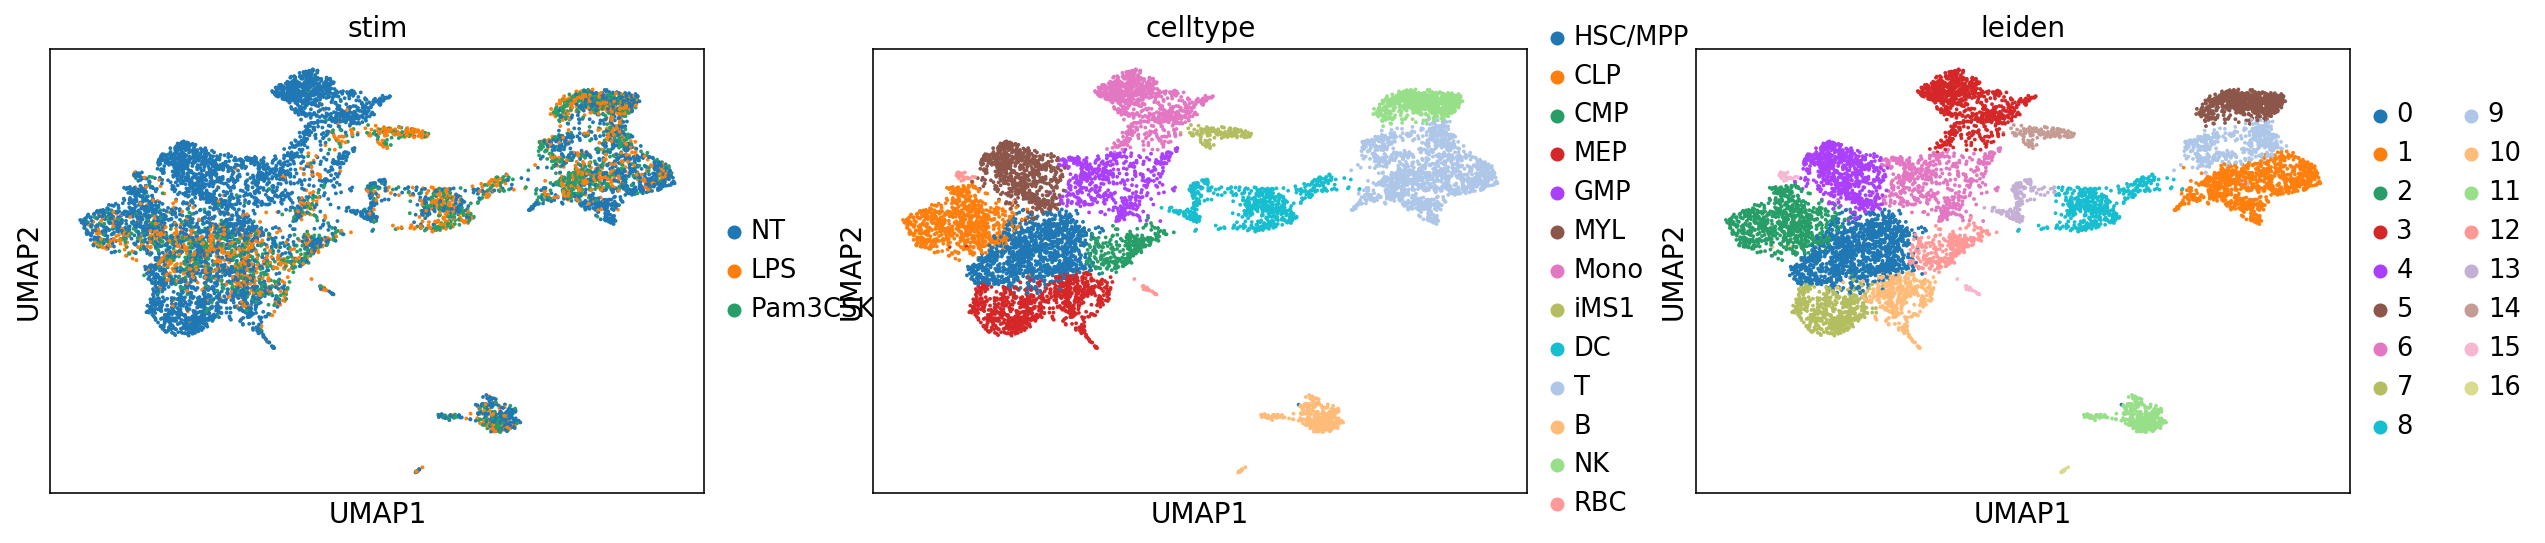

In [4]:
sc.pl.umap(adata, color=['stim','celltype','leiden'])

### Differential Expression iMS1 vs. Mono

ranking genes
    finished: added to `.uns['DE_mono']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:01)
    using 'X_pca' with n_pcs = 50
Storing dendrogram info using `.uns['dendrogram_leiden']`


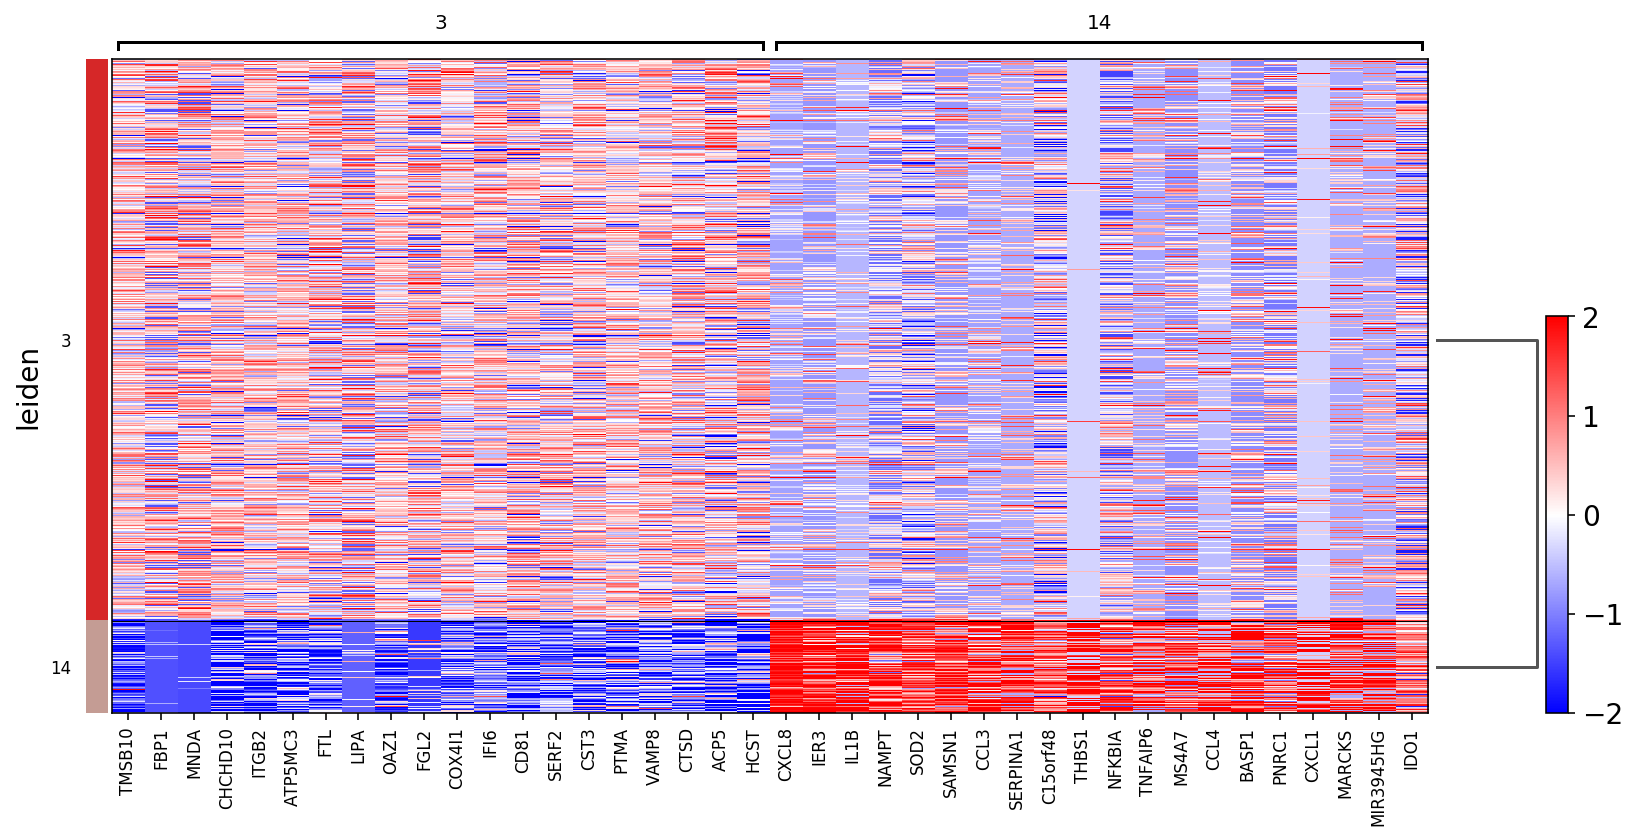

In [5]:
adata.obs['celltype'][adata.obs['celltype']=='iMS1'] = 'Mono'
adata_sub = adata[adata.obs['celltype']=='Mono']
adata_sub.X = adata_sub.raw.X
sc.pp.scale(adata_sub)

sc.tl.rank_genes_groups(adata_sub, groupby='leiden', key_added='DE_mono', method='wilcoxon')
sc.pl.rank_genes_groups_heatmap(adata_sub, key='DE_mono', use_raw=False, cmap='bwr', vmin=-2, vmax=2, n_genes=20)

### Get fractions of iMS1 cluster among total monos

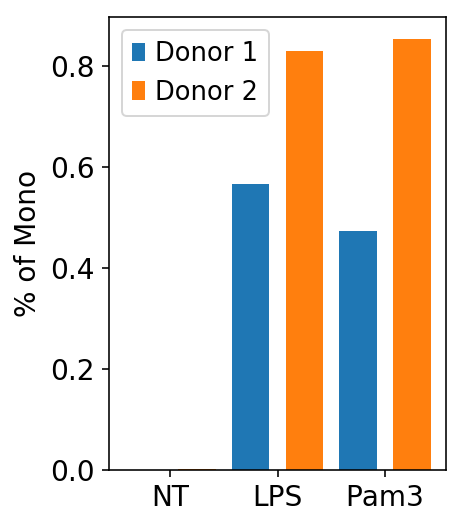

In [6]:
fracs = np.zeros([2,3])

for i, i_stim in enumerate(['NT','LPS','Pam3CSK4']):
    for j, j_d in enumerate(['P1','P2']):
        fracs[j,i] = sum(adata.obs['leiden'][(adata.obs['stim']==i_stim) & (adata.obs['donor']==j_d)]=='14')/ \
                     sum(adata.obs['celltype'][(adata.obs['stim']==i_stim) & (adata.obs['donor']==j_d)]=='Mono')
        
plt.figure(figsize=(3,4))
plt.bar([-0.5,1.5,3.5], fracs[0], color='tab:blue', width=0.7, label='Donor 1')
plt.bar([0.5,2.5,4.5], fracs[1], color='tab:orange', width=0.7, label='Donor 2')
plt.grid(None)
plt.xticks([0,2,4],labels=['NT','LPS','Pam3'])
plt.ylabel('% of Mono')
plt.legend()

### Try computing an MS1 score

computing score 'MS1_score'
    finished: added
    'MS1_score', score of gene set (adata.obs) (0:00:01)


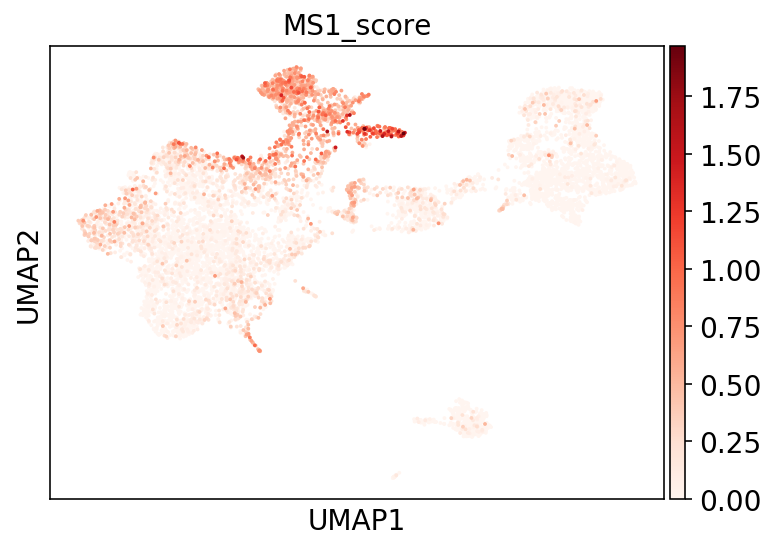

In [7]:
ms1_markers = ['RETN','ALOX5AP','CD63','SEC61G','TXN','MT1X','FOS','SOD2','NCF1','IL1R2',
               'THBS1','DPYSL2','PTPRE','C6orf62','FES','CD164','TM9SF2','PRKAR1A','SLC25A37','YWHAE']
sc.tl.score_genes(adata, ms1_markers,
                  score_name='MS1_score')

sc.pl.umap(adata, color=['MS1_score'], cmap='Reds', vmin=0)

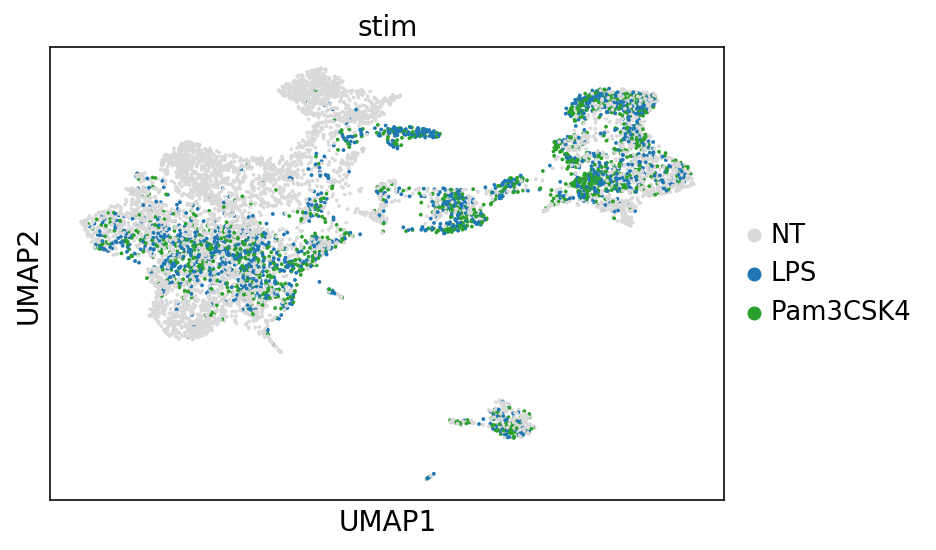

In [8]:
sc.pl.umap(adata, color=['stim'], palette=['0.85','tab:blue','tab:green'], vmin=0)

### Look for DE receptors in progenitor populations

In [9]:
rl_df = pd.read_csv('./receptor_ligand_pairs.csv')
rl_df = rl_df.iloc[:,[0,1,3]]
receptors = list(rl_df['Receptor.ApprovedSymbol'])
diff_genes_rl_all = pd.DataFrame()

ranking genes


... storing 'compare' as categorical


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:02)


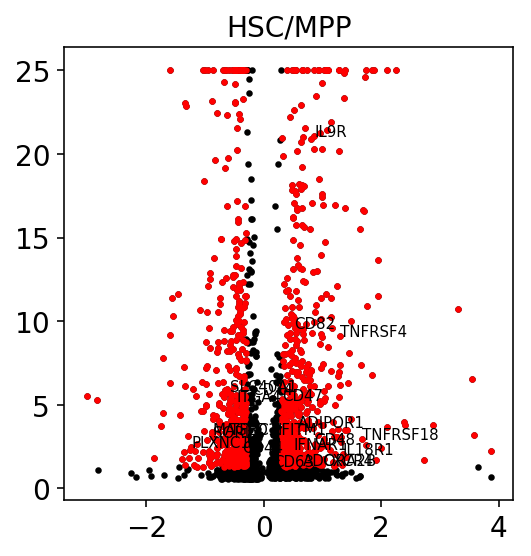

In [10]:
test_celltype = 'HSC/MPP'

adata.obs['compare'] = 'NA'
adata.obs['compare'][(adata.obs['celltype']==test_celltype) & (adata.obs['stim'].isin(['LPS','Pam3CSK4']))] = 'TLR-Stim'
adata.obs['compare'][(adata.obs['celltype']==test_celltype) & (adata.obs['stim'].isin(['NT']))] = 'NT'

sc.tl.rank_genes_groups(adata, groupby='compare', groups=['TLR-Stim'], reference='NT',
                        n_genes=1000, method='wilcoxon')
up_df = sc.get.rank_genes_groups_df(adata, group='TLR-Stim')

sc.tl.rank_genes_groups(adata, groupby='compare', groups=['NT'], reference='TLR-Stim',
                        n_genes=1000, method='wilcoxon')
down_df = sc.get.rank_genes_groups_df(adata, group='NT')

down_df['logfoldchanges'] = -down_df['logfoldchanges'].values
combined_df = up_df.append(down_df)
combined_df['-log10p'] = -np.log10(combined_df['pvals_adj'])

diff_genes = combined_df[combined_df['pvals_adj'] < 0.05]
diff_genes_rl = diff_genes[diff_genes['names'].isin(receptors)]
combined_df['-log10p'][combined_df['-log10p'] > 25] = 25
combined_df = combined_df[combined_df['-log10p']>0.1]

plt.figure(figsize=(4,4))
plt.scatter(combined_df['logfoldchanges'], combined_df['-log10p'], s=5, c='k')
de_df = combined_df[((combined_df['logfoldchanges'] > 0.3) | (combined_df['logfoldchanges'] < -0.3)) & (combined_df['pvals_adj'] < 0.05)]
plt.scatter(de_df['logfoldchanges'], de_df['-log10p'], s=5, c='red')
plt.grid(False)
for i in diff_genes_rl.index:
    plt.annotate(diff_genes_rl['names'][i],(diff_genes_rl['logfoldchanges'][i],diff_genes_rl['-log10p'][i]), size=7.5)
plt.title(test_celltype)

diff_genes_rl['cell_type'] = test_celltype
diff_genes_rl_all = diff_genes_rl_all.append(diff_genes_rl)

### Trajectory analysis

In [11]:
adata = sc.read('./matrix_bm.h5ad')
adata = adata[adata.obs['celltype'].isin(['HSC/MPP','GMP','CMP','Mono','iMS1'])]
adata = adata[adata.obs['stim'].isin(['LPS','Pam3CSK4'])]

In [12]:
sc.pp.neighbors(adata)
sc.tl.umap(adata, min_dist=0.25, n_components=3)
adata.uns['iroot'] = np.flatnonzero(adata.obs['celltype'] == 'HSC/MPP')[0]
sc.tl.dpt(adata, n_dcs=10, n_branchings=0)
sc.tl.paga(adata, groups='celltype')

computing neighbors
    using 'X_pca' with n_pcs = 50
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:06)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:03)
computing Diffusion Maps using n_comps=15(=n_dcs)
computing transitions
    finished (0:00:00)
    eigenvalues of transition matrix
    [1.         0.9950202  0.9732261  0.9633462  0.9433036  0.93176836
     0.9230598  0.90896255 0.9015502  0.8892422  0.87862736 0.8773226
     0.86905766 0.8400696  0.8308984 ]
    finished: added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns) (0:00:00)
computing Diffusion Pseudotime using n_dcs=10
    finished: added
    'dpt_pseudotime', the pseudotime (adata.obs) (0:00:00)
running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectiviti

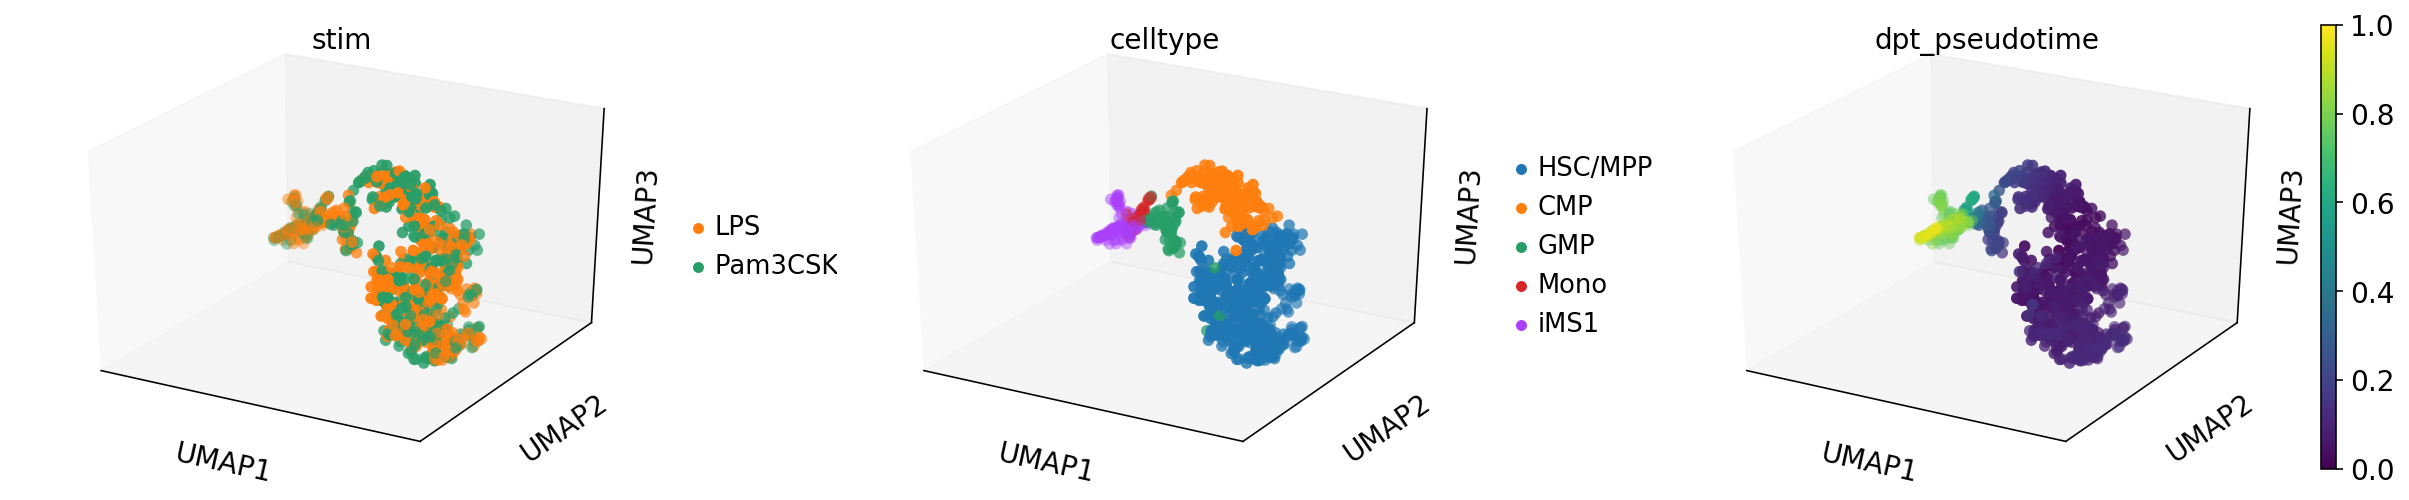

In [13]:
sc.pl.umap(adata, color=['stim','celltype','dpt_pseudotime'], projection='3d')

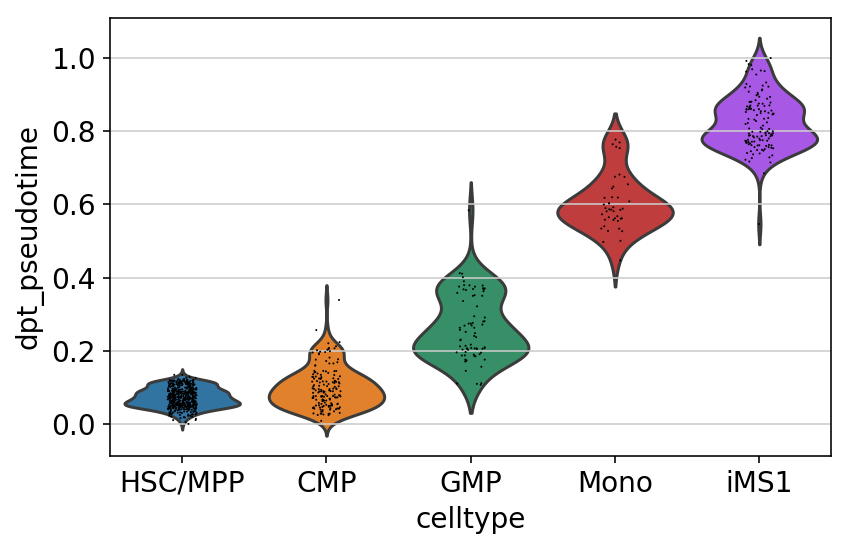

In [14]:
sc.pl.violin(adata, keys=['dpt_pseudotime'], groupby='celltype')

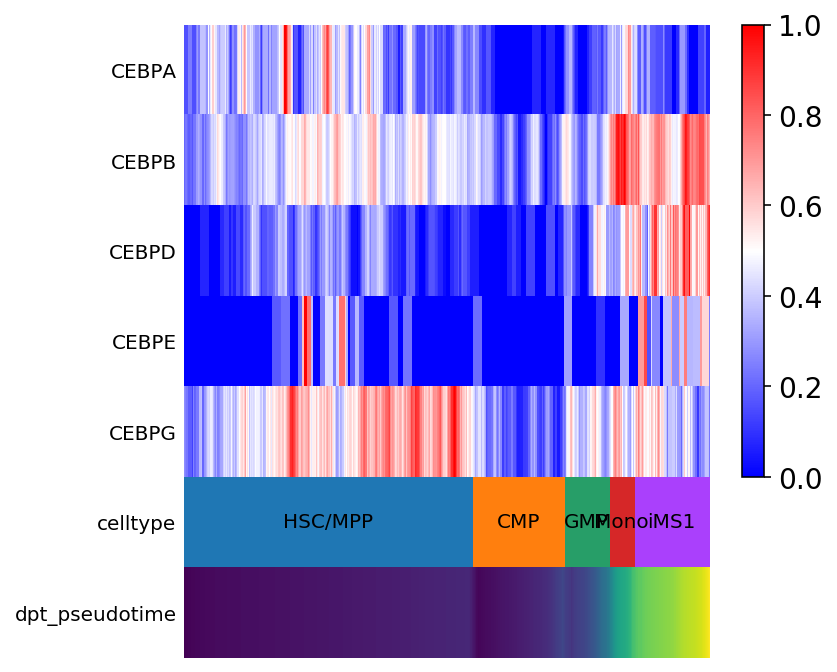

In [15]:
sc.pl.paga_path(adata, nodes=['HSC/MPP','CMP','GMP','Mono','iMS1'], keys=['CEBPA','CEBPB','CEBPD','CEBPE','CEBPG'],
                normalize_to_zero_one=True, color_map = 'bwr', n_avg=15, 
                color_maps_annotations={'dpt_pseudotime':'viridis'})